In [5]:
%load_ext autoreload
%autoreload 2

import torch
import matplotlib.pyplot as plt

import lightning as L
import numpy as np

from models.base.varnet_primitive import SMEBlock
from models.base.unet import NormUnet
from dataset import SliceDataModule
import fastmri
from models.varnet_rough_sens_faster import VarNetRoughSensFaster
from models.varnet_rough_sens import VarNetRoughSens
from models.varnet_logistic_sens import VarNetLogisticSens
from models.varnet_logistic_unet_sens_fix import VarNetLogisticUnetSensFix
from models import VarNetLogisticBoundL1OL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# sens_chans = 8
# sens_pools = 4

# sens_net_path = "checkpoints/sens_net/for_Sens.pt"
# sens_net_state_dict = torch.load(sens_net_path)
# sens_net = SMEBlock(
#     image_processor=NormUnet(sens_chans, sens_pools)
# )

# # Replace StateDict with new keys
# keys = sens_net.state_dict().keys()
# new_state_dict = {}
# for key in keys:
#     new_state_dict[key] = sens_net_state_dict[key.replace("image_processor.", "norm_unet.")]
# sens_net.load_state_dict(new_state_dict)
# sens_net = sens_net.cuda()

In [6]:
HASH = "a4a4b606c1664612ae130bee6a38cf57"
checkpoint_path = f"mlartifacts/0/{HASH}/artifacts/checkpoints/latest_checkpoint.pth"
checkpoint = torch.load(checkpoint_path)
hparams = checkpoint["hyper_parameters"]
del hparams["_class_path"]
del hparams["_instantiator"]
model = VarNetLogisticBoundL1OL(**hparams)
model.load_state_dict(torch.load(checkpoint_path)["state_dict"])
sens_net = model.sens_net.cuda()

In [4]:
# torch.save(model, "checkpoints/VarNetLogisticUnetSensFix.pt")

In [7]:
dm = SliceDataModule(root='/Data')
dm.setup('train')

In [8]:
train_loader = dm.train_dataloader()

In [19]:
mask, masked_kspace, target, maximum, fname, sl = next(iter(train_loader))
mask.shape, masked_kspace.shape, target.shape, maximum, fname, sl

(torch.Size([1, 1, 1, 396, 1]),
 torch.Size([1, 14, 768, 396, 2]),
 torch.Size([1, 384, 384]),
 tensor([0.0006], dtype=torch.float64),
 ('brain_acc8_8.h5',),
 tensor([3]))

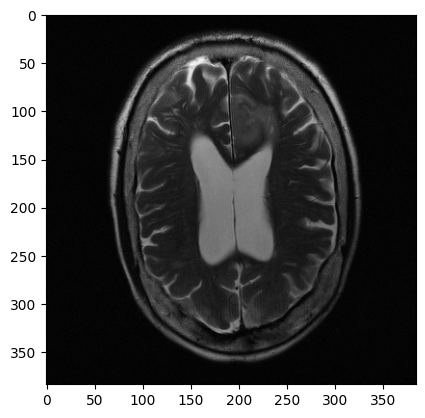

In [20]:
plt.imshow(target[0], cmap='gray')
plt.show()

In [21]:
mask = mask.cuda()
masked_kspace = masked_kspace.cuda()

with torch.no_grad():
    sens_map = model.sens_net(masked_kspace, mask)

In [22]:
lowres = fastmri.ifft2c(masked_kspace).cpu().numpy()

lowres_real = lowres[..., 0]
lowres_imag = lowres[..., 1]
lowres_theta = np.arctan2(lowres_imag, lowres_real)
lowres_abs = np.abs(lowres_real + 1j * lowres_imag)
lowres_ratio = lowres_real / lowres_imag

In [23]:
sens_map_real = sens_map[..., 0].cpu().numpy()
sens_map_imag = sens_map[..., 1].cpu().numpy()
sens_map_theta = np.arctan2(sens_map_imag, sens_map_real)
sens_map_abs = np.abs(sens_map_real + 1j * sens_map_imag)
sens_map_ratio = sens_map_real / sens_map_imag

In [24]:
def visualize(img, circular=False):
    kwargs = {'cmap': 'gray', 'vmin': -1, 'vmax': 1} if not circular else {
        'cmap': 'twilight', 'vmin': -np.pi, 'vmax': np.pi
    }

    img = fastmri.data.transforms.center_crop(img, (384, 384))
    img /= abs(img).max()

    if not circular and img.min() >= 0:
        kwargs['vmin'] = 0

    C = img.shape[0]
    T = int(np.sqrt(C))
    fig, axes = plt.subplots((C - 1) // T + 1, T, figsize=(12, 18))

    for c in range(C):
        axes[c//T, c%T].imshow(img[c], **kwargs)
        axes[c//T, c%T].set_title(f'Coil {c+1}')

    plt.tight_layout()
    plt.show()

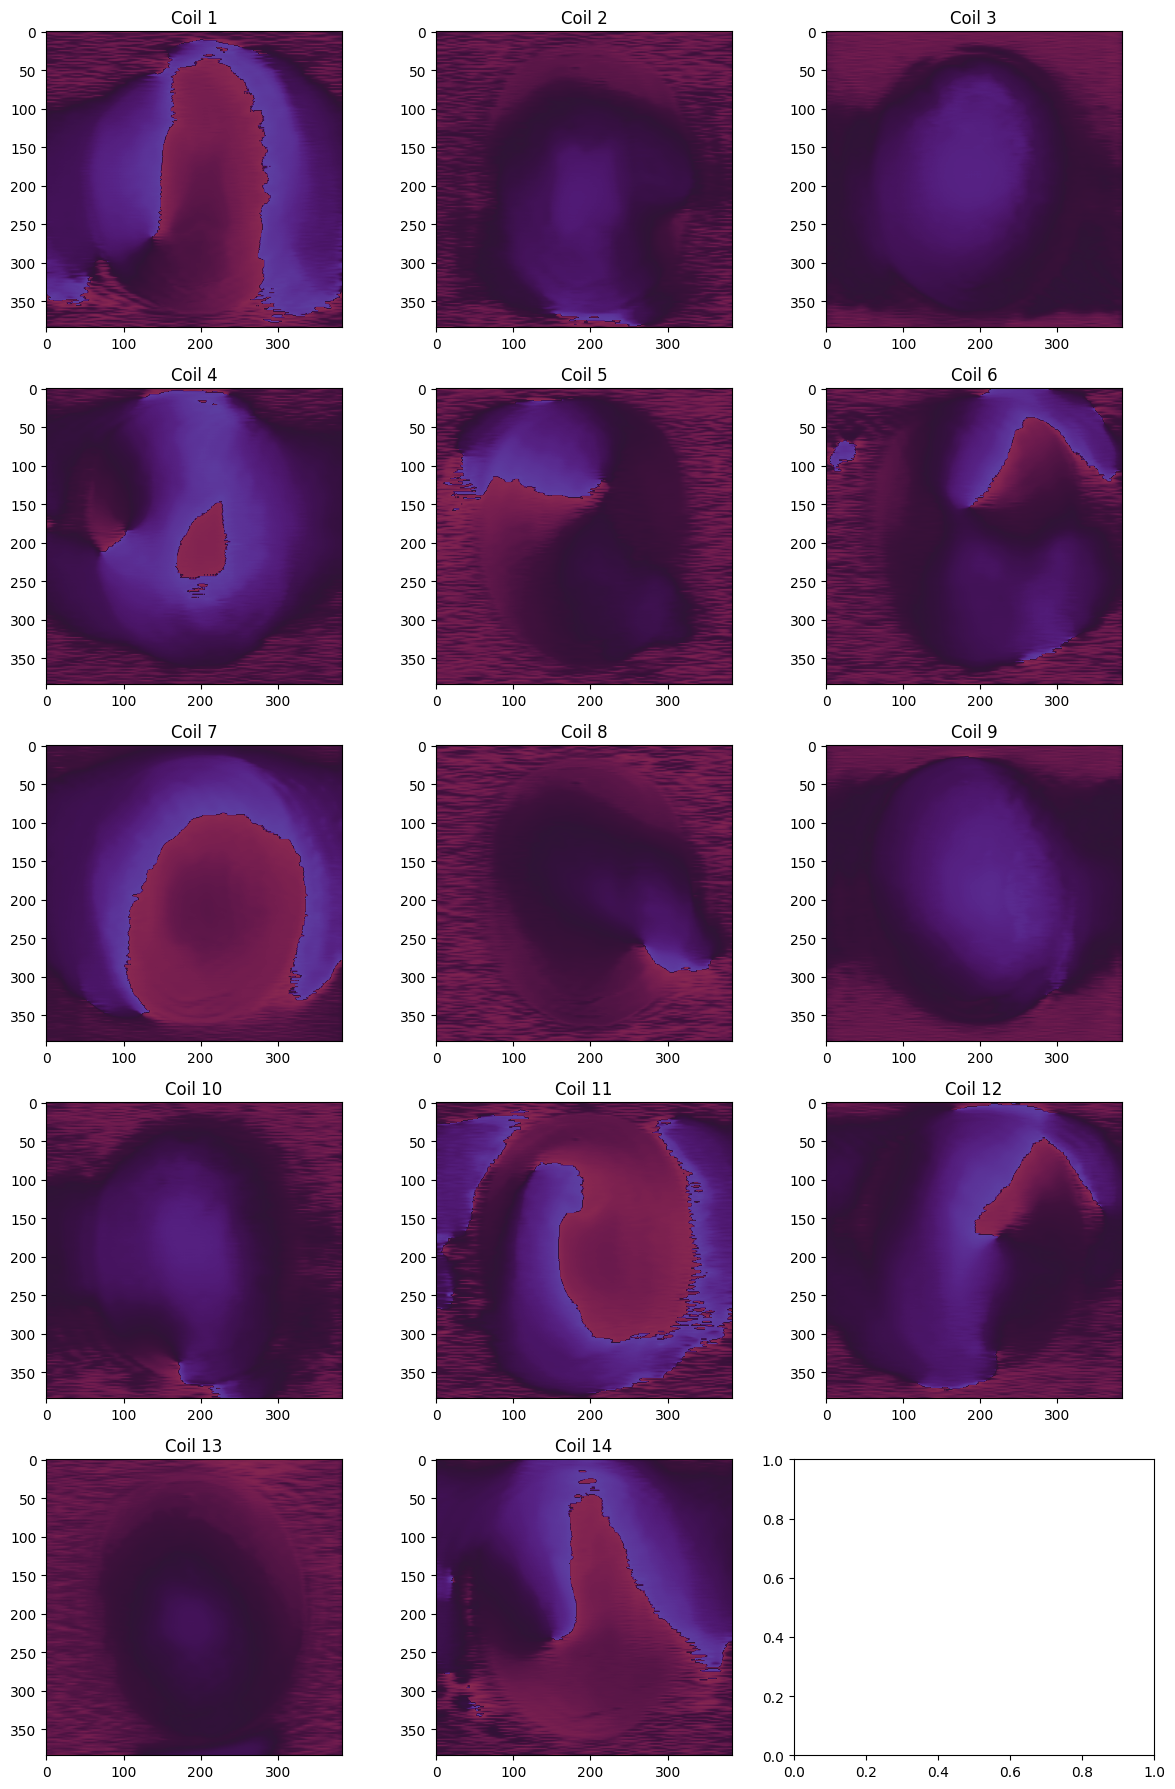

In [25]:
visualize(sens_map_theta[0], circular=True)

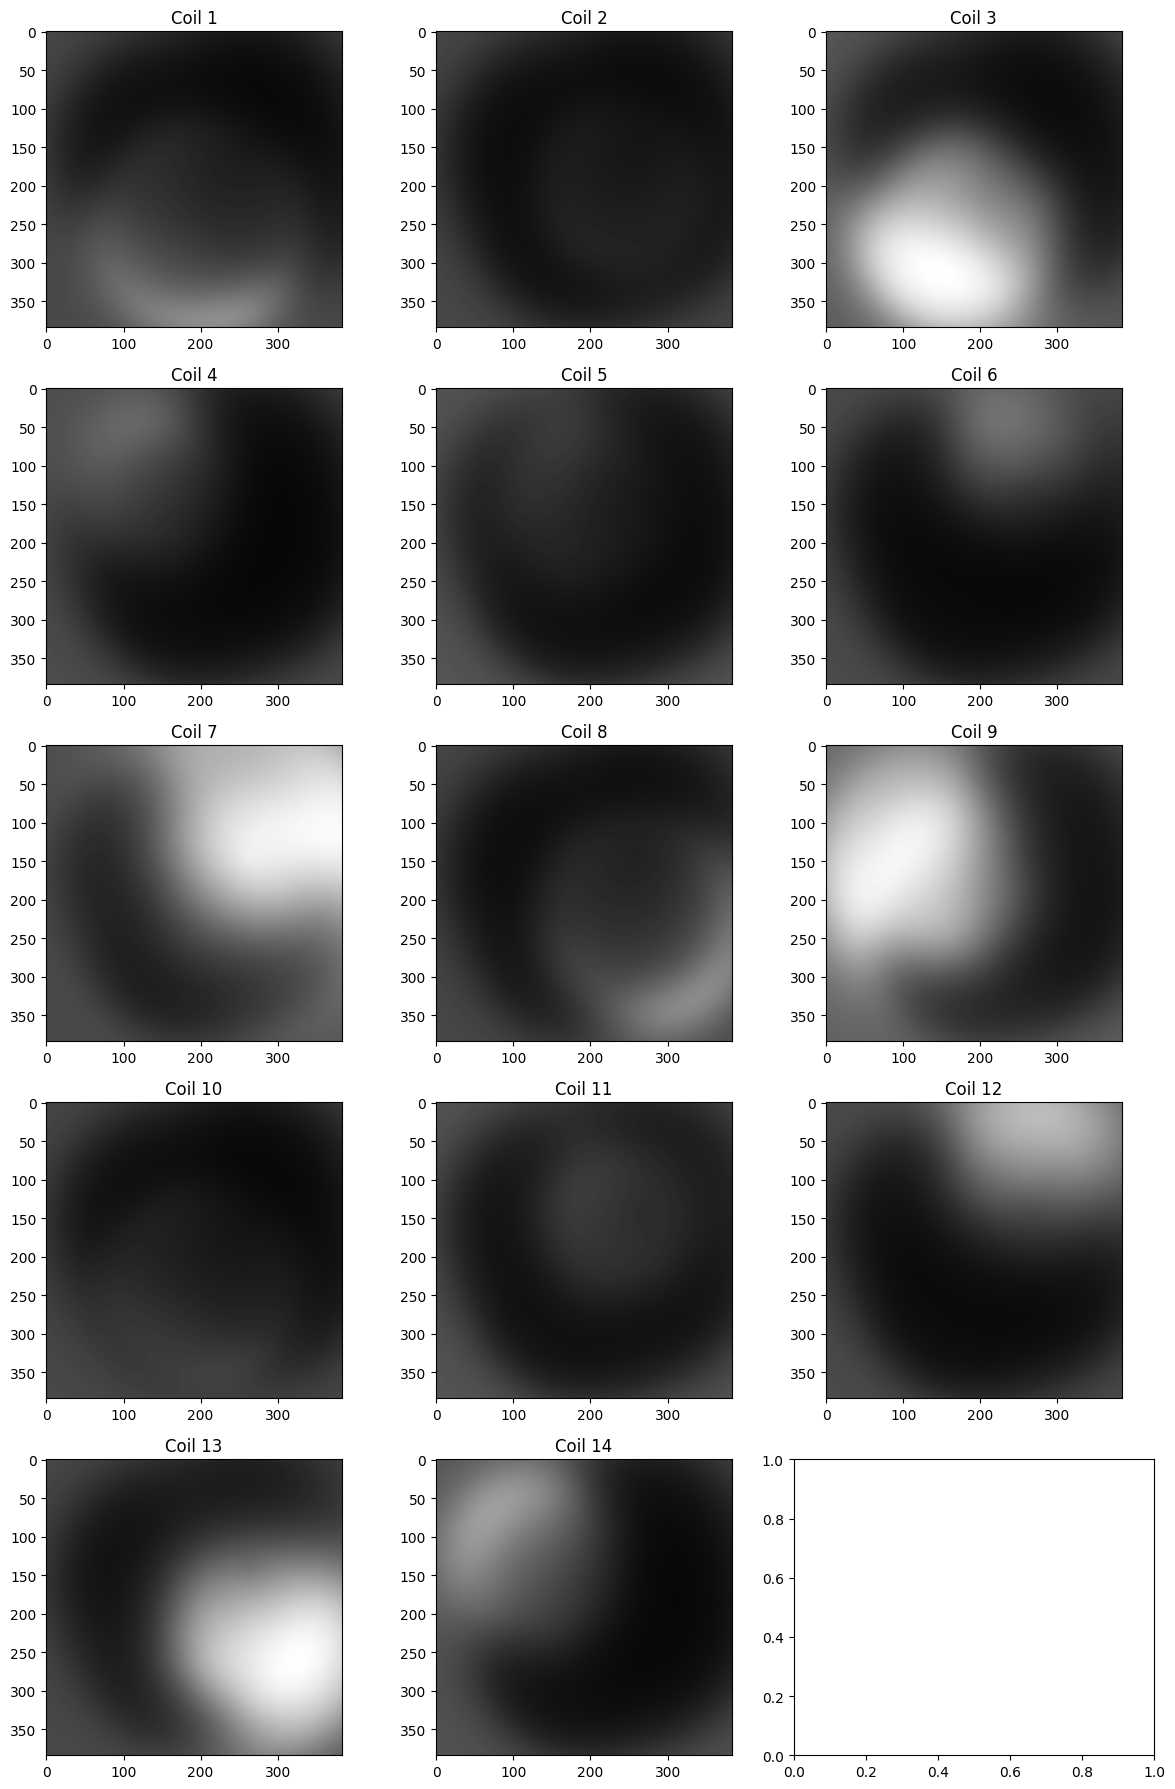

In [26]:
visualize(sens_map_abs[0])

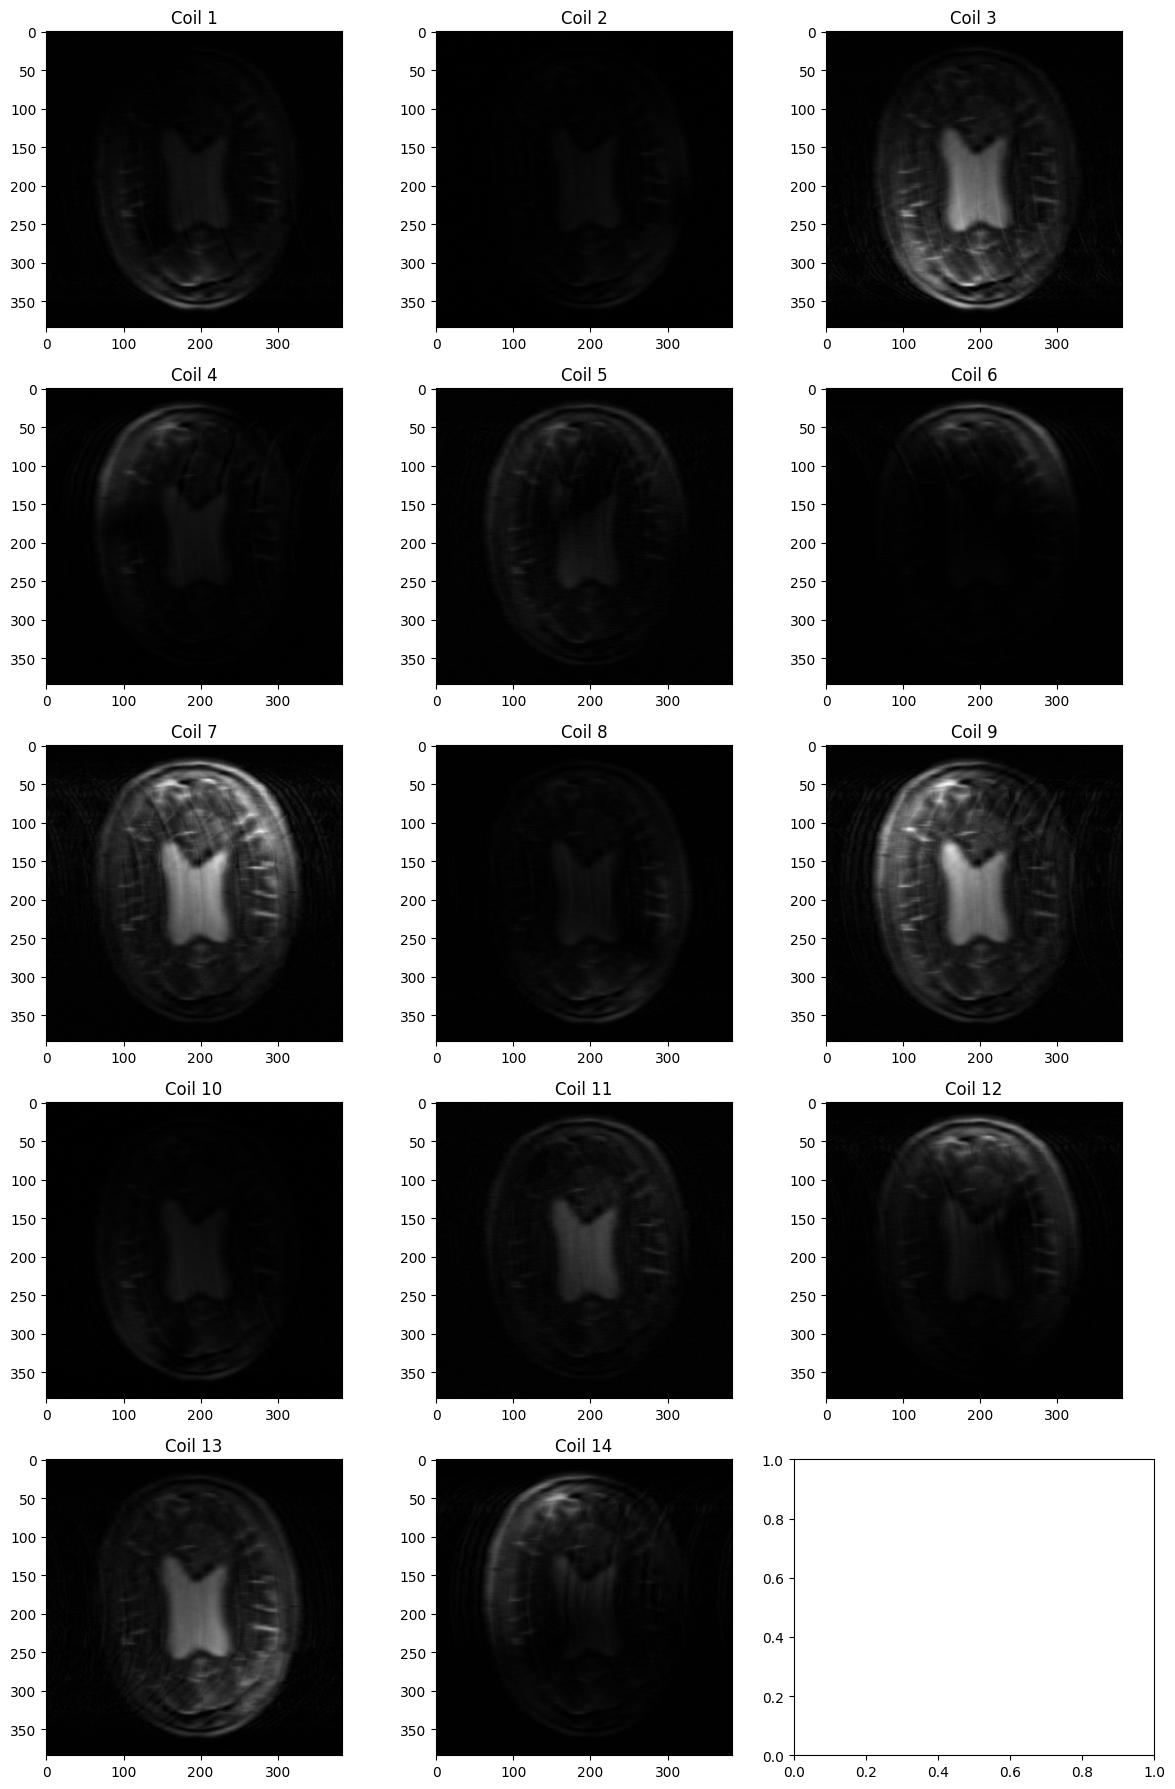

In [27]:
visualize(lowres_abs[0])

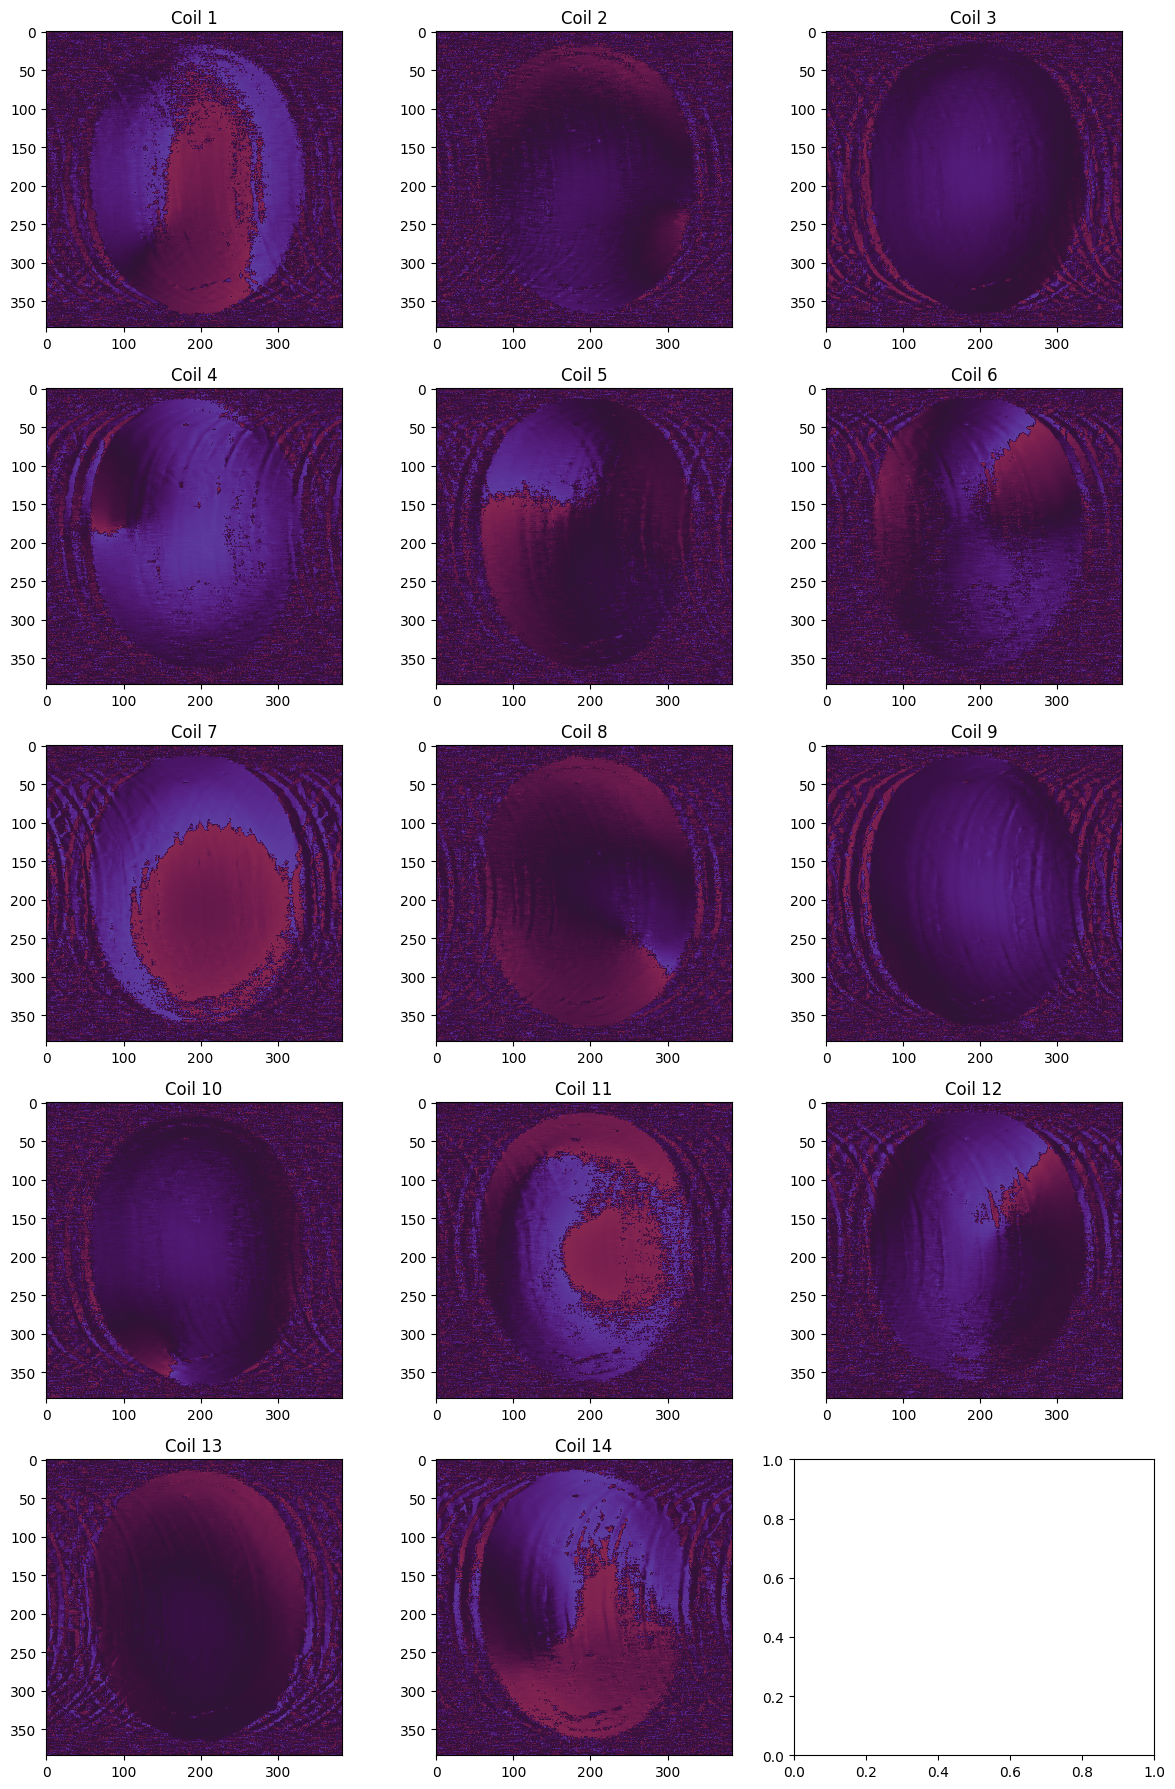

In [28]:
visualize(lowres_theta[0], circular=True)